In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def add_season_to_df(df):
    df = df.reset_index()
    df["season"] = np.nan
    df.loc[df.time.dt.month.isin([12, 1, 2]), "season"] = "DJF"
    df.loc[df.time.dt.month.isin([3, 4, 5]), "season"] = "MAM"
    df.loc[df.time.dt.month.isin([6, 7, 8]), "season"] = "JJA"
    df.loc[df.time.dt.month.isin([9, 10, 11]), "season"] = "SON"
    return df

In [3]:
def read_in_data(init):
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [4]:
init = "12"
gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_in_data(
    init
)

nam_fcast_and_error_df = add_season_to_df(nam_fcast_and_error_df)
gfs_fcast_and_error_df = add_season_to_df(gfs_fcast_and_error_df)
hrrr_fcast_and_error_df = add_season_to_df(hrrr_fcast_and_error_df)

In [5]:
def get_nysm_site_info():
    nysm_info = pd.read_csv(
        "/home/aevans/nwp_bias/src/landtype/notebooks/nysm_coords.csv"
    )
    nysm_info = nysm_info[["station", "latitude", "longitude"]]
    nysm_info = nysm_info.set_index("station")
    return nysm_info

In [6]:
def load_nysm_data(year):
    path_to_data = "/home/aevans/nwp_bias/data/nysm/"

    nysm_1H_obs = pd.read_parquet(f"{path_to_data}nysm_1H_obs_{year}.parquet")
    nysm_3H_obs = pd.read_parquet(f"{path_to_data}nysm_3H_obs_{year}.parquet")
    return nysm_1H_obs, nysm_3H_obs


years = np.arange(2018, 2022)

nysm_1H_obs_save = []
nysm_3H_obs_save = []
for year in years:
    print(year)
    nysm_1H, nysm_3H = load_nysm_data(str(year))
    nysm_1H_obs_save.append(nysm_1H)
    nysm_3H_obs_save.append(nysm_3H)

nysm_1H_obs = pd.concat(nysm_1H_obs_save)
nysm_3H_obs = pd.concat(nysm_3H_obs_save)

2018
2019
2020
2021


In [7]:
def plot_bias_ratio(merged_df, model, title_opt):
    latN = 45.2
    latS = 40.2
    lonW = -79.8
    lonE = -71.8
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2

    res = "50m"
    proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig = plt.figure(
        figsize=(8, 4), dpi=200
    )  # Increase the dots per inch from default 100 to make plot easier to read
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent([lonW, lonE, latS, latN])
    ax.add_feature(cfeature.LAND.with_scale(res))
    ax.add_feature(cfeature.OCEAN.with_scale(res))
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.LAKES.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res))

    s1 = ax.scatter(
        merged_df["longitude"],
        merged_df["latitude"],
        c=merged_df["bias ratio"],
        s=50,
        vmin=0.5,
        vmax=1.5,
        cmap=cm.BrBG,
        edgecolors="grey",
        transform=ccrs.PlateCarree(),
        zorder=4,
    )
    cbar = plt.colorbar(s1, extend="both", orientation="vertical")
    cbar.set_label("Bias Ratio")

    mean = merged_df["bias ratio"].mean()
    stddev = merged_df["bias ratio"].std()

    ax.text(
        0.02,
        0.02,
        f"Mean = {np.round(mean, 2)}\nStddev = {np.round(stddev, 2)}",
        transform=ax.transAxes,
    )

    if title_opt:
        ax.set_title(f"{model}: " + title_opt)
    else:
        ax.set_title(f"{model}")

In [8]:
def get_bias_ratio(df, model):
    df = df.reset_index()
    df = df[df["lead_time_DAY"] == 0]
    df = df[df["lead_time_HOUR"] <= 18]
    summed_stns = df.groupby("station")[[f"new_tp_{model}", "new_tp_nysm"]].sum()
    summed_stns["bias ratio"] = (
        summed_stns[f"new_tp_{model}"] / summed_stns["new_tp_nysm"]
    )

    nysm_info = get_nysm_site_info()
    merged_df = pd.merge(summed_stns, nysm_info, on="station")
    return merged_df

In [9]:
def format_plot_df(tippity_df, keys):
    plot_df = pd.DataFrame()
    stat_ls = []
    lat_ls = []
    lon_ls = []
    # bias_ls = []
    for i, _ in enumerate(tippity_df["station"]):
        if tippity_df["station"].iloc[i] in keys:
            stations = tippity_df["station"].iloc[i]
            lats = tippity_df["latitude"].iloc[i]
            lons = tippity_df["longitude"].iloc[i]
            # bias = tippity_df['bias_ratio'].iloc[i]
            stat_ls.append(stations)
            lat_ls.append(lats)
            lon_ls.append(lons)
            # bias_ls.append(bias)
    plot_df["station"] = stat_ls
    plot_df["latitude"] = lat_ls
    plot_df["longitude"] = lon_ls
    # plot_df['bias_ratio'] = bias_ls

    return plot_df

In [10]:
nysm_avg_precip = (
    nysm_1H_obs[nysm_1H_obs["precip_total"] > 0.0]
    .groupby("station")[["precip_total"]]
    .mean()
)

In [11]:
br_hrrr = get_bias_ratio(hrrr_fcast_and_error_df, "HRRR")
br_nam = get_bias_ratio(nam_fcast_and_error_df, "NAM")
br_gfs = get_bias_ratio(gfs_fcast_and_error_df, "GFS")

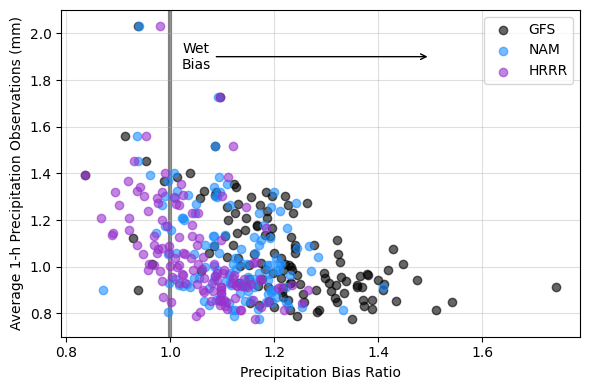

In [12]:
plt.figure(figsize=(6, 4), dpi=100)
ax = plt.subplot(111)
plt.scatter(
    br_gfs["bias ratio"],
    nysm_avg_precip["precip_total"],
    c="k",
    label="GFS",
    alpha=0.6,
    zorder=2,
)
plt.scatter(
    br_nam["bias ratio"],
    nysm_avg_precip["precip_total"],
    c="dodgerblue",
    label="NAM",
    alpha=0.6,
    zorder=2,
)
plt.scatter(
    br_hrrr["bias ratio"],
    nysm_avg_precip["precip_total"],
    c="darkorchid",
    label="HRRR",
    alpha=0.6,
    zorder=2,
)
plt.legend(loc=0)
ax.annotate(
    "Dry\nBias",
    xy=(0.75, 1.9),
    xycoords="data",
    xytext=(0.95, 1.9),
    textcoords="data",
    horizontalalignment="center",
    verticalalignment="center",
    arrowprops=dict(arrowstyle="->", lw=1),
)
ax.annotate(
    "Wet\nBias",
    xy=(1.5, 1.9),
    xycoords="data",
    xytext=(1.05, 1.9),
    textcoords="data",
    horizontalalignment="center",
    verticalalignment="center",
    arrowprops=dict(arrowstyle="->", lw=1),
)
plt.vlines(1, 0.7, 2.1, colors="grey", zorder=1, linewidths=3)
plt.grid(True, alpha=0.4)
plt.ylim([0.7, 2.1])
plt.xlabel("Precipitation Bias Ratio")
plt.ylabel("Average 1-h Precipitation Observations (mm)")
plt.tight_layout()

In [13]:
def get_bias_ratio_and_plot(df, model, title_opt):
    merged_df = get_bias_ratio(df, model)
    plot_bias_ratio(merged_df, model, title_opt)

In [14]:
def plot_bias_ratio_boxplot(df_in, model, title_opt):
    df = get_bias_ratio(df_in, model)
    plt.figure(dpi=100)
    df.groupby("station").boxplot(
        column="bias ratio", subplots=False, rot=90, figsize=(4, 5)
    )
    # plt.hlines(1,0.5,len(clim_div)+0.5, colors='k', linestyles=':')
    # plt.xticks(np.arange(1,len(clim_div)+1), clim_div)
    plt.xlabel("Climate Division")
    plt.ylabel("Bias Ratio")
    plt.title(f"{model} " + title_opt)
    plt.ylim([0.75, 1.75])
    plt.tight_layout()

In [15]:
def plot_bias_ratio_boxplot_season(df_in, model, season):
    df = get_bias_ratio(df_in[df_in["season"] == season], model)
    plt.figure(dpi=100)
    df.groupby("station").boxplot(
        column="bias ratio", subplots=False, rot=90, figsize=(4, 5)
    )
    # plt.hlines(1,0.5,len(clim_div)+0.5, colors='k', linestyles=':')
    # plt.xticks(np.arange(1,len(clim_div)+1), clim_div)
    plt.xlabel("Climate Division")
    plt.ylabel("Bias Ratio")
    plt.title(f"{model}: {season}")
    plt.ylim([0.5, 2.0])
    plt.tight_layout()

In [16]:
bottom_ls = [
    "MANH",
    "BKLN",
    "QUEE",
    "TANN",
    "BRON",
    "CLAR",
    "STAT",
    "STON",
    "ELDR",
    "REDF",
    "WANT",
    "WARW",
    "SUFF",
]
top_ls = [
    "CAPE",
    "SARA",
    "CHAZ",
    "BURT",
    "ESSX",
    "LOUI",
    "POTS",
    "EDWA" "WELL",
    "ELLE",
    "BROC",
    "ONTA",
    "MALO",
]

In [21]:
hrrr_df = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"].isin(bottom_ls)]
nam_df = nam_fcast_and_error_df[nam_fcast_and_error_df["station"].isin(bottom_ls)]
gfs_df = gfs_fcast_and_error_df[gfs_fcast_and_error_df["station"].isin(bottom_ls)]

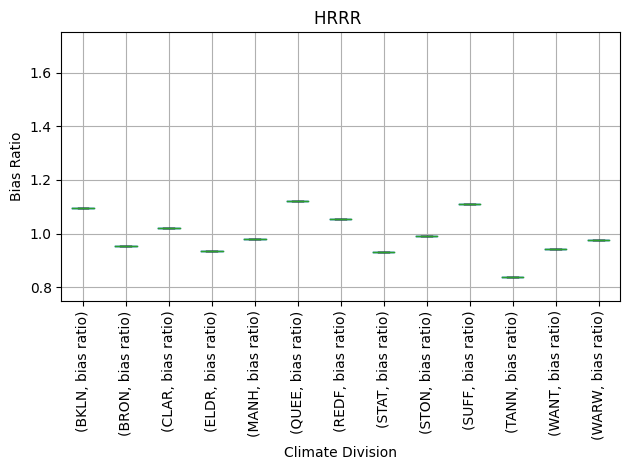

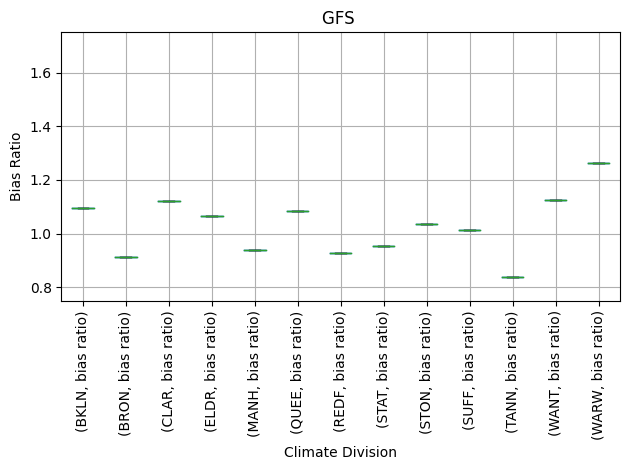

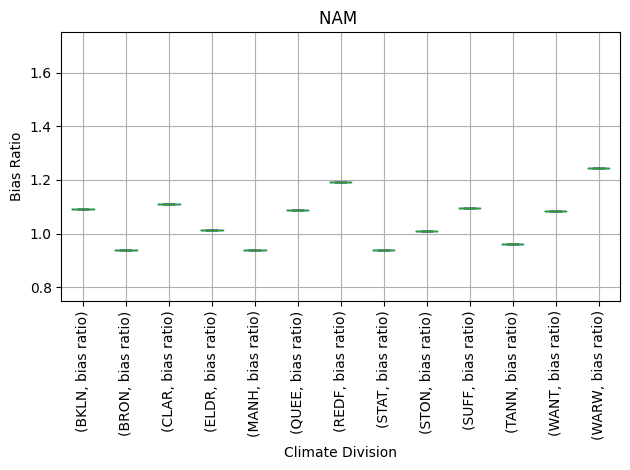

In [22]:
plot_bias_ratio_boxplot(hrrr_df, "HRRR", "")
plot_bias_ratio_boxplot(gfs_df, "GFS", "")
plot_bias_ratio_boxplot(nam_df, "NAM", "")

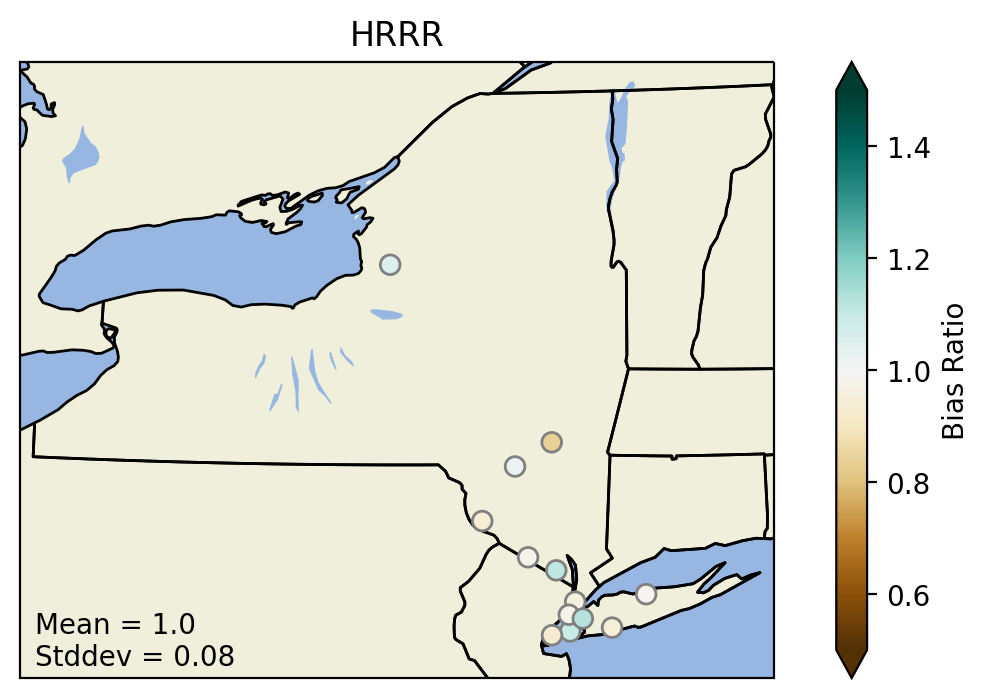

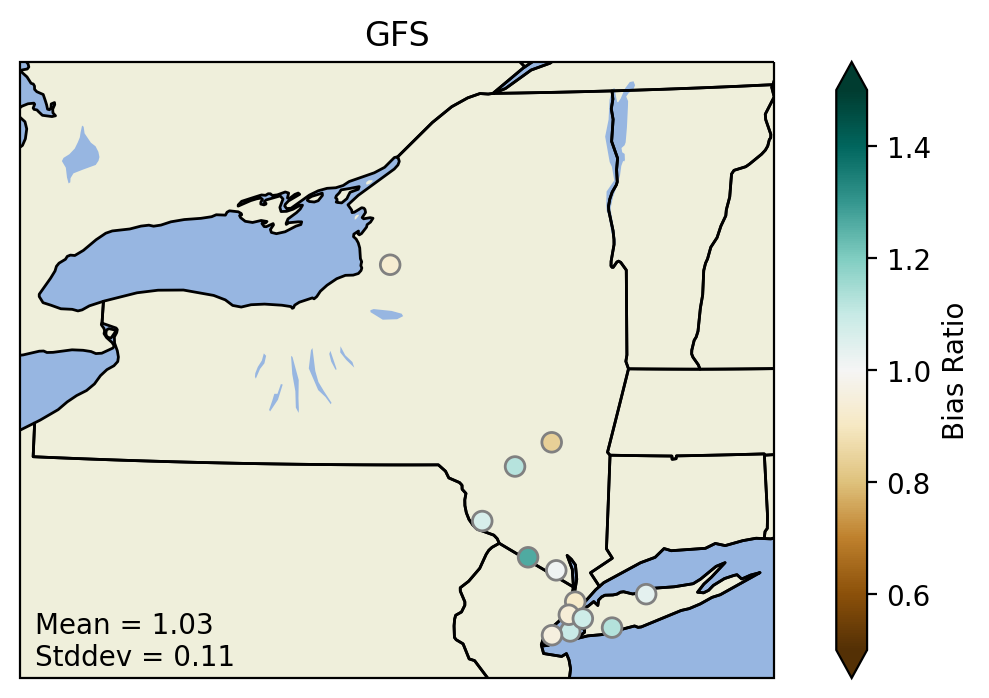

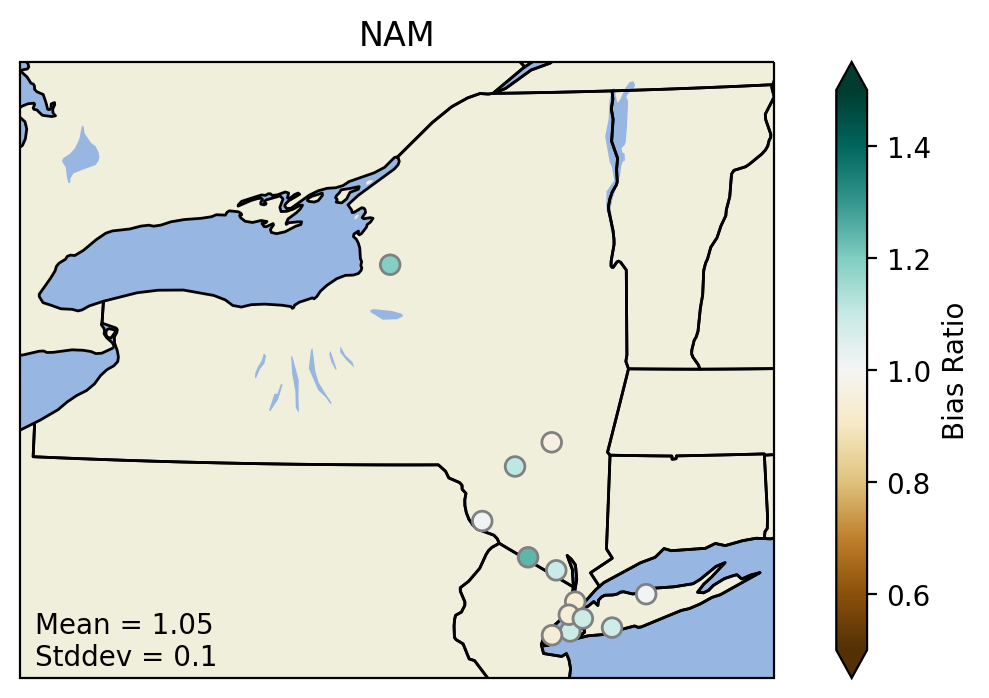

In [23]:
get_bias_ratio_and_plot(hrrr_df, "HRRR", "")
get_bias_ratio_and_plot(gfs_df, "GFS", "")
get_bias_ratio_and_plot(nam_df, "NAM", "")

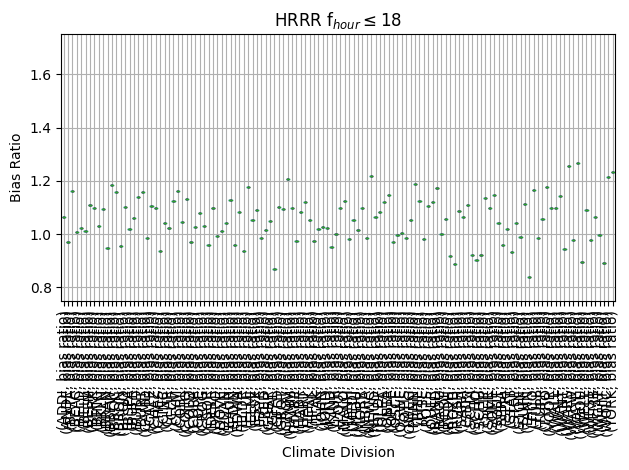

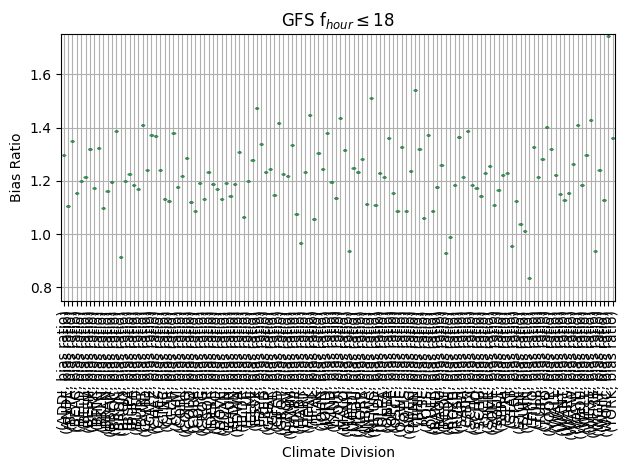

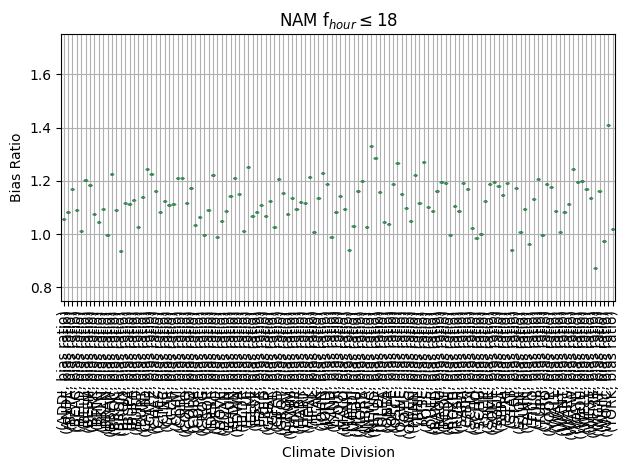

In [24]:
plot_bias_ratio_boxplot(
    hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "HRRR",
    "f$_{hour} \leq$18",
)
plot_bias_ratio_boxplot(
    gfs_fcast_and_error_df[gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "GFS",
    "f$_{hour} \leq$18",
)
plot_bias_ratio_boxplot(
    nam_fcast_and_error_df[nam_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18],
    "NAM",
    "f$_{hour} \leq$18",
)

In [25]:
def get_bias_ratio_season(df, model):
    df = df.reset_index()
    summed_stns = df.groupby(["season", "station"])[
        [f"new_tp_{model}", "new_tp_nysm"]
    ].sum()
    summed_stns["bias ratio"] = (
        summed_stns[f"new_tp_{model}"] / summed_stns["new_tp_nysm"]
    )

    nysm_info = get_nysm_site_info()
    merged_df = pd.merge(summed_stns.reset_index(), nysm_info, on="station")
    return merged_df.set_index(["season"])

In [26]:
hrrr_biasratio_seasons = get_bias_ratio_season(
    hrrr_fcast_and_error_df[(hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18)],
    "HRRR",
)
nam_biasratio_seasons = get_bias_ratio_season(
    nam_fcast_and_error_df[(nam_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18)],
    "NAM",
)
gfs_biasratio_seasons = get_bias_ratio_season(
    gfs_fcast_and_error_df[(gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18)],
    "GFS",
)

In [27]:
nwp_biasratio_seasons = pd.DataFrame()

nwp_biasratio_seasons["HRRR"] = hrrr_biasratio_seasons.groupby("season")[
    "bias ratio"
].mean()
nwp_biasratio_seasons["NAM"] = nam_biasratio_seasons.groupby("season")[
    "bias ratio"
].mean()
nwp_biasratio_seasons["GFS"] = gfs_biasratio_seasons.groupby("season")[
    "bias ratio"
].mean()

In [28]:
nwp_biasratio_seasons = nwp_biasratio_seasons.T[["DJF", "MAM", "JJA", "SON"]].T

Text(0.5, 1.0, '$f_{hour}\\leq18$')

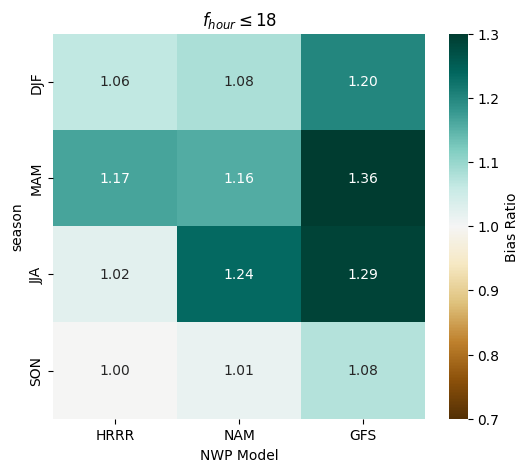

In [29]:
plt.figure(figsize=(6, 5), dpi=100)
sns.heatmap(
    nwp_biasratio_seasons,
    cmap=cm.BrBG,
    annot=True,
    fmt="0.2f",
    vmin=0.7,
    vmax=1.3,
    cbar_kws={"label": "Bias Ratio"},
)
plt.xlabel("NWP Model")
plt.title("$f_{hour}\leq18$")

In [30]:
nam_biasratio_seasons_later = get_bias_ratio_season(
    nam_fcast_and_error_df[
        (nam_fcast_and_error_df["lead_time_ONLY_HOURS"] > 18)
        & (nam_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 84)
    ],
    "NAM",
)
gfs_biasratio_seasons_later = get_bias_ratio_season(
    gfs_fcast_and_error_df[
        (gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] > 18)
        & (gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 84)
    ],
    "GFS",
)

nwp_biasratio_seasons_later = pd.DataFrame()

nwp_biasratio_seasons_later["NAM"] = nam_biasratio_seasons_later.groupby("season")[
    "bias ratio"
].mean()
nwp_biasratio_seasons_later["GFS"] = gfs_biasratio_seasons_later.groupby("season")[
    "bias ratio"
].mean()
nwp_biasratio_seasons_later = nwp_biasratio_seasons_later.T[
    ["DJF", "MAM", "JJA", "SON"]
].T

Text(0.5, 1.0, '$18 < f_{hour} \\leq84$')

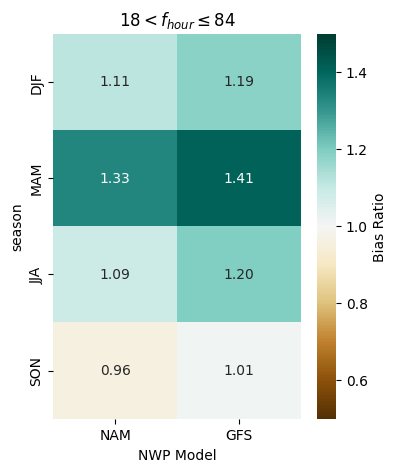

In [31]:
plt.figure(figsize=(4, 5), dpi=100)
sns.heatmap(
    nwp_biasratio_seasons_later,
    cmap=cm.BrBG,
    annot=True,
    fmt="0.2f",
    vmin=0.5,
    vmax=1.5,
    cbar_kws={"label": "Bias Ratio"},
)
plt.xlabel("NWP Model")
plt.title("$18 < f_{hour} \leq84$")

/tmp/tmp.LqGrKwrxFy/ipykernel_755528/2697303605.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  get_bias_ratio_and_plot(gfs_fcast_and_error_df[(gfs_fcast_and_error_df['season']==season) &
/tmp/tmp.LqGrKwrxFy/ipykernel_755528/2697303605.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  get_bias_ratio_and_plot(gfs_fcast_and_error_df[(gfs_fcast_and_error_df['season']==season) &
/tmp/tmp.LqGrKwrxFy/ipykernel_755528/2697303605.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  get_bias_ratio_and_plot(gfs_fcast_and_error_df[(gfs_fcast_and_error_df['season']==season) &
/tmp/tmp.LqGrKwrxFy/ipykernel_755528/2697303605.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  get_bias_ratio_and_plot(gfs_fcast_and_error_df[(gfs_fcast_and_error_df['season']==season) &


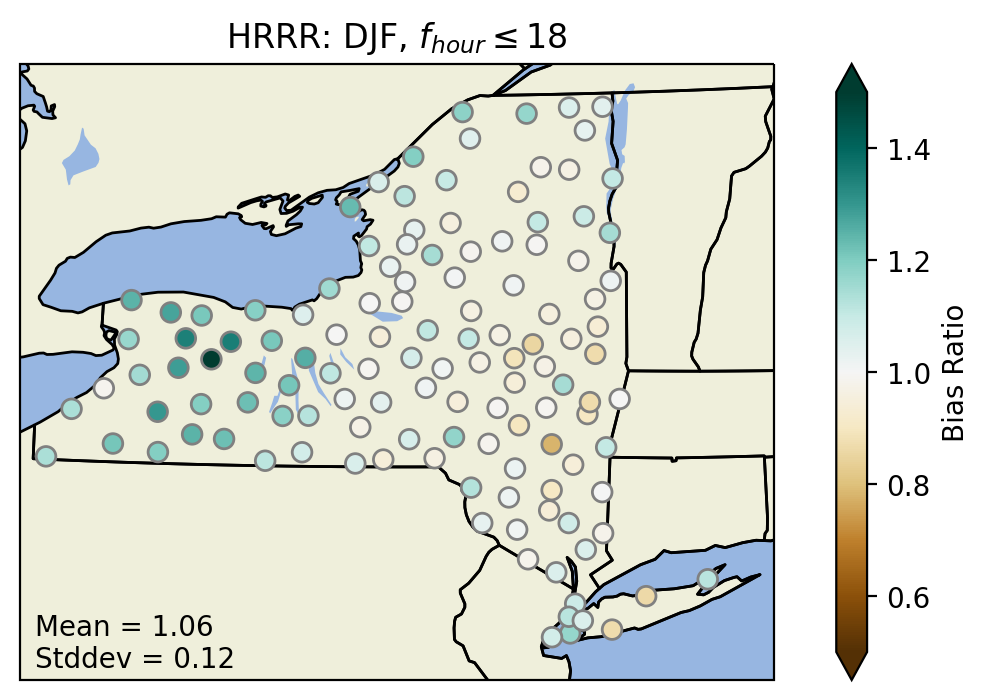

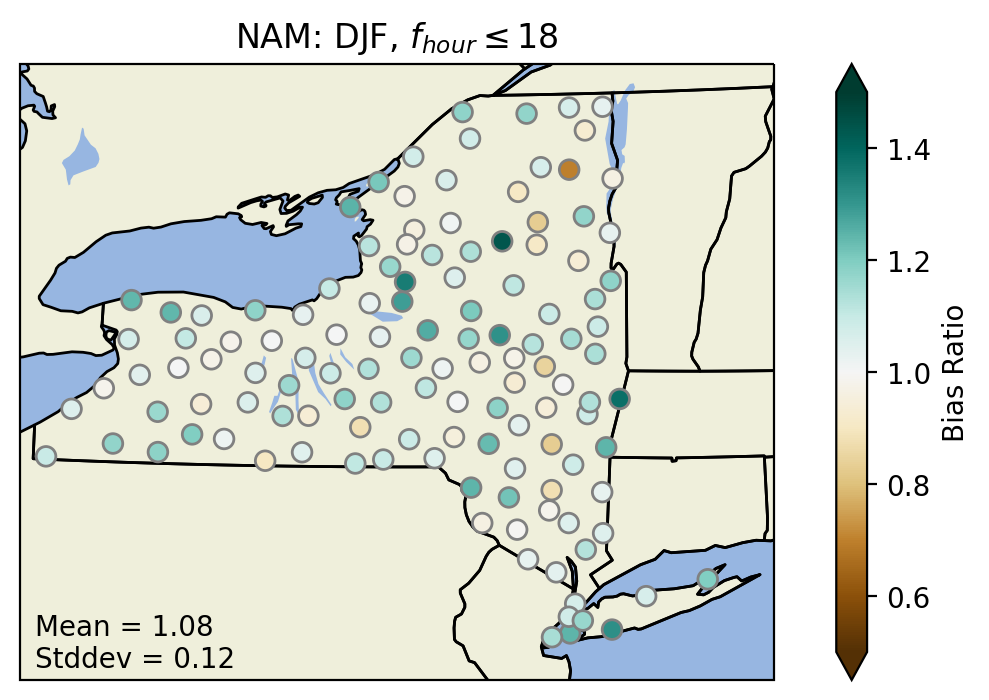

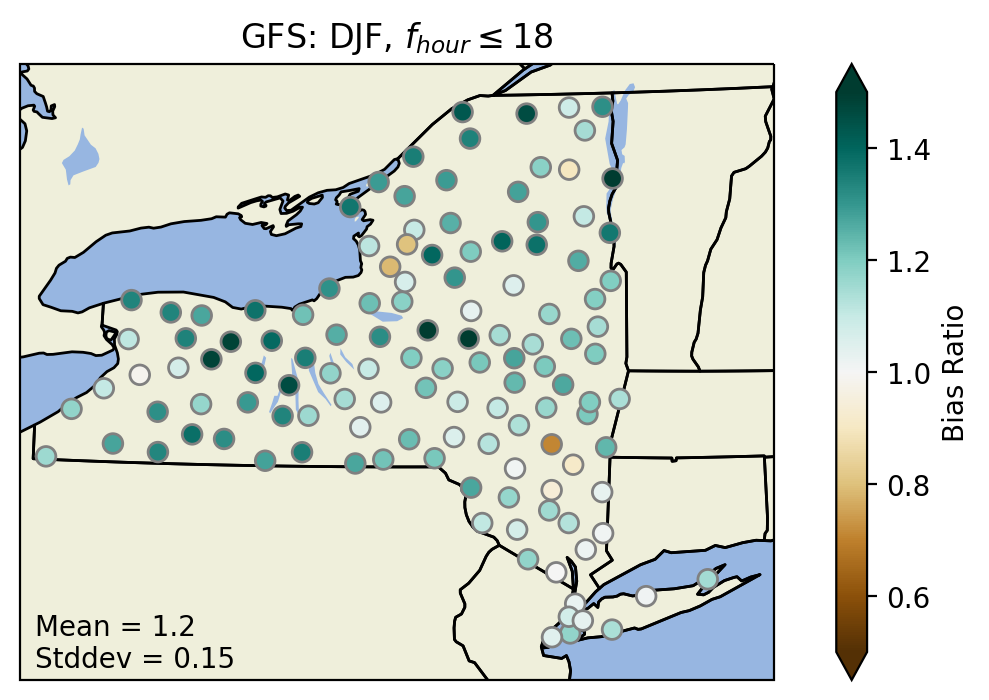

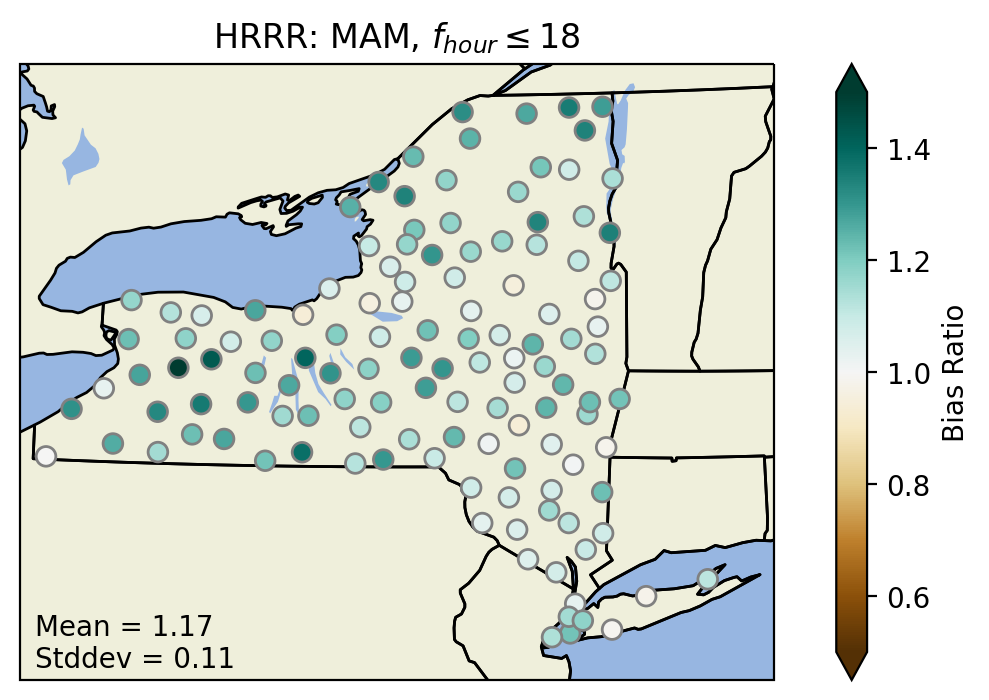

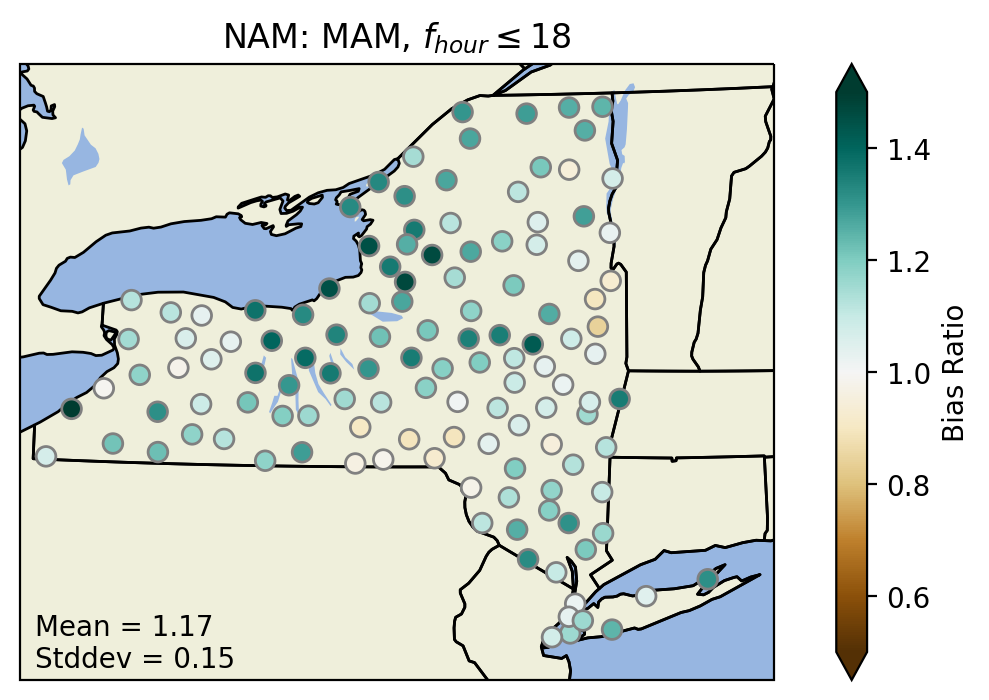

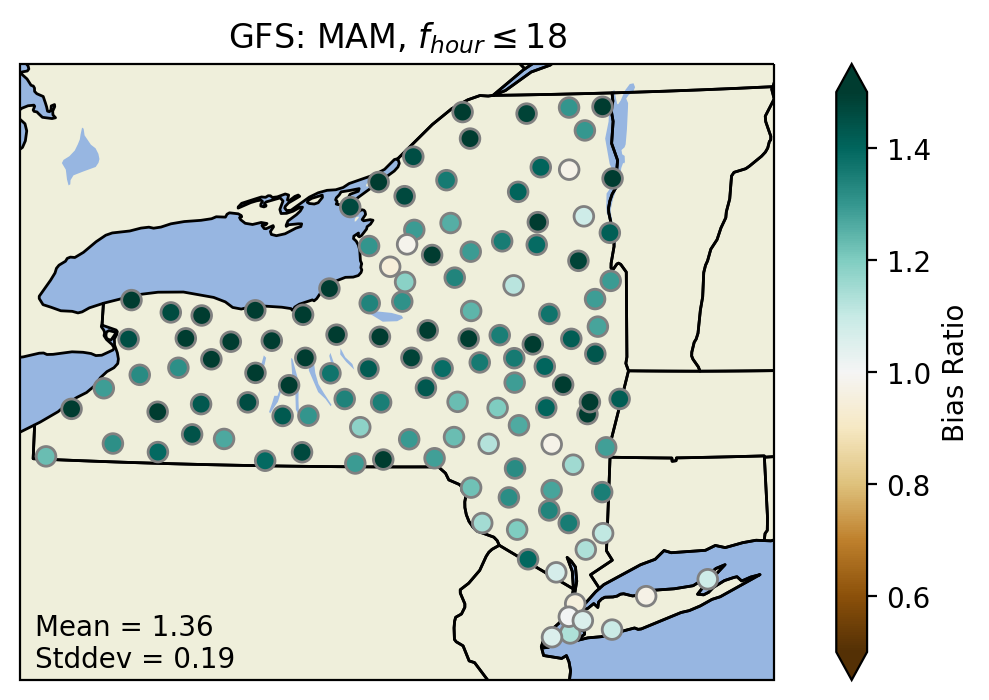

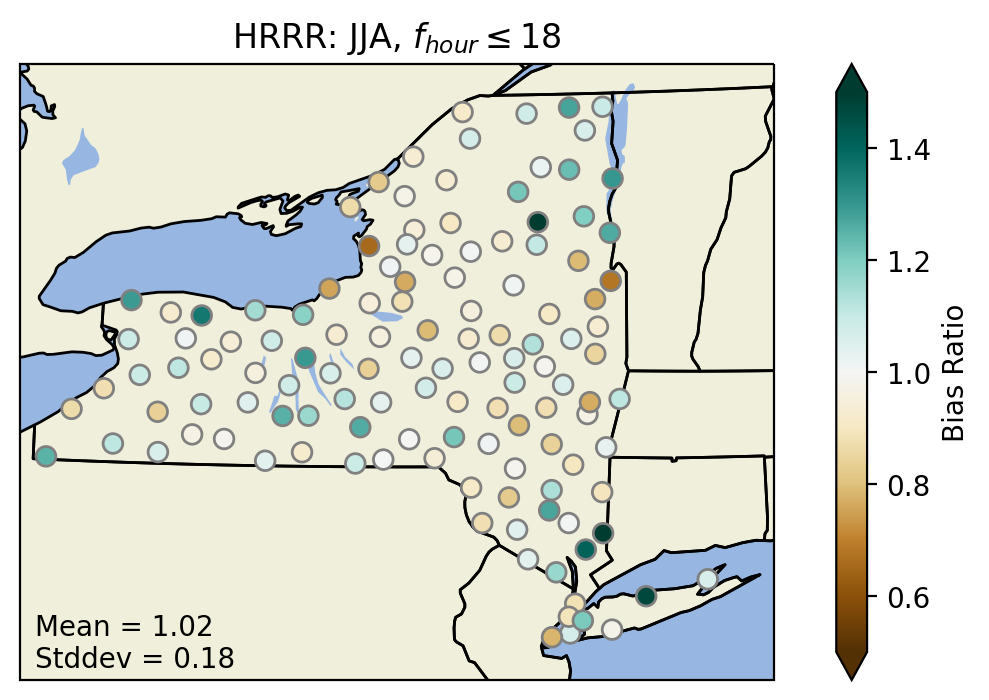

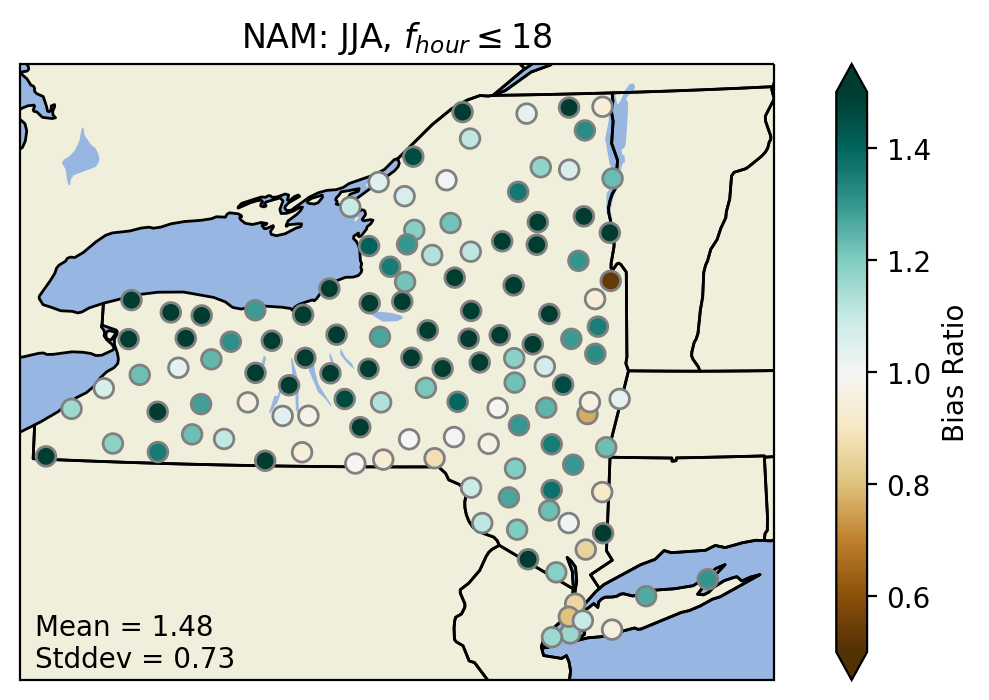

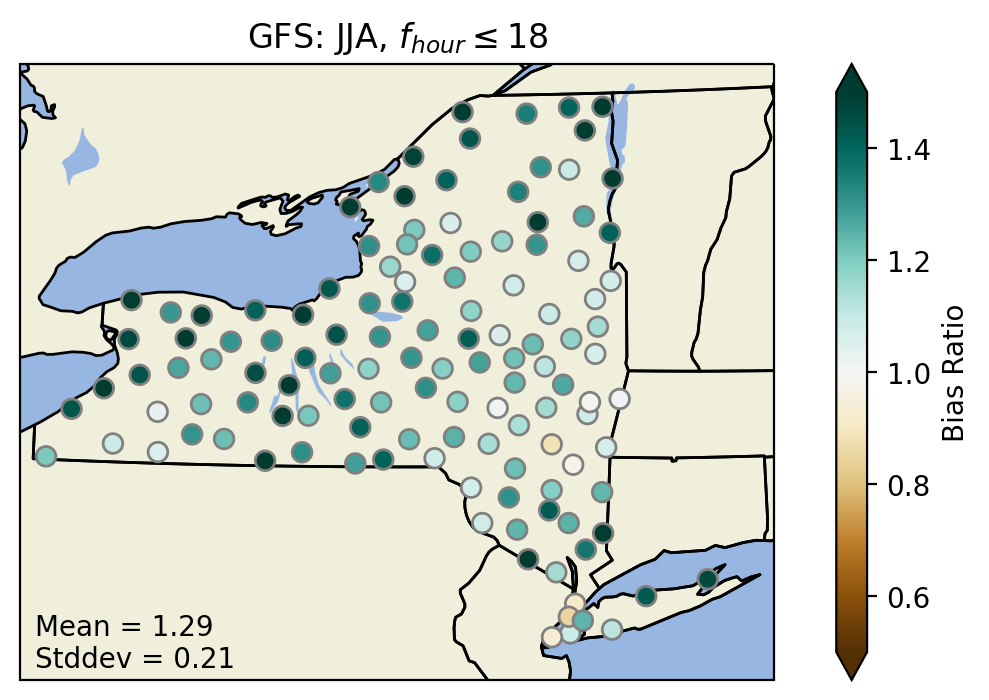

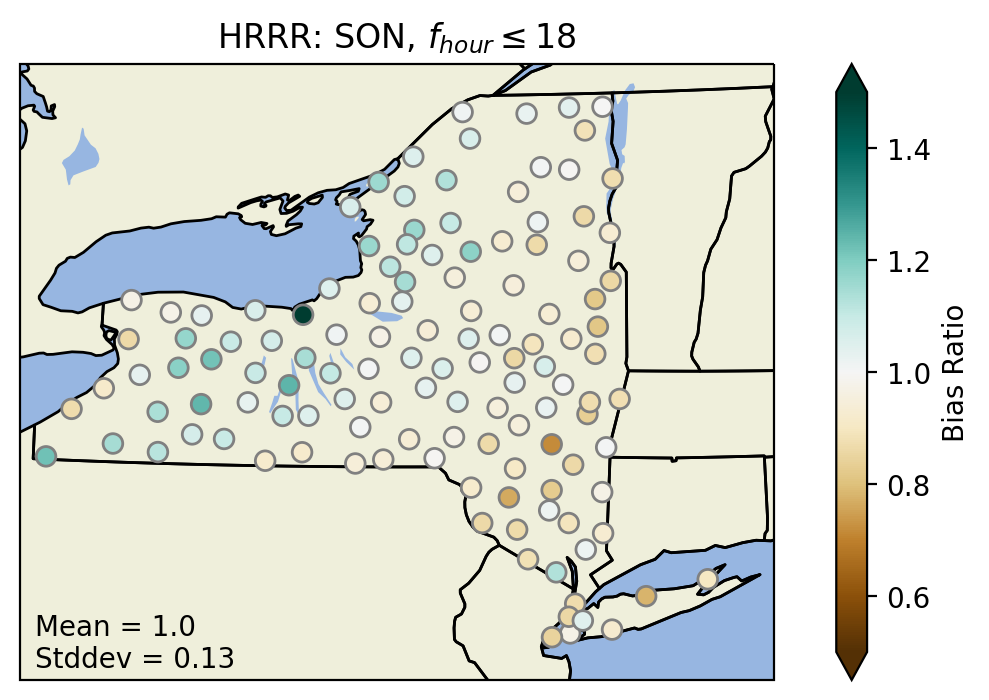

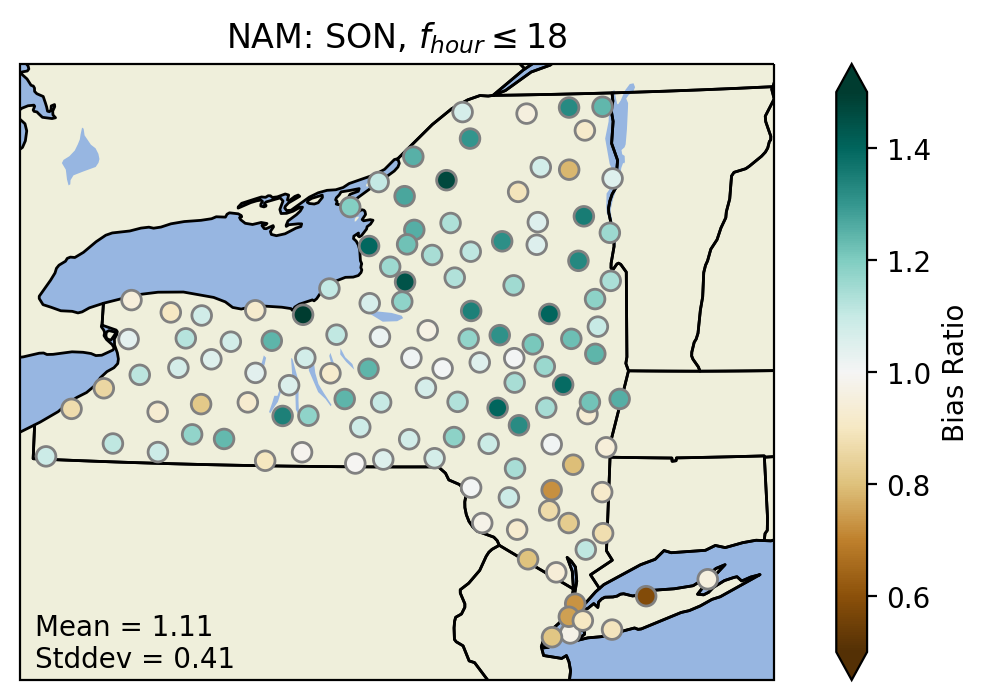

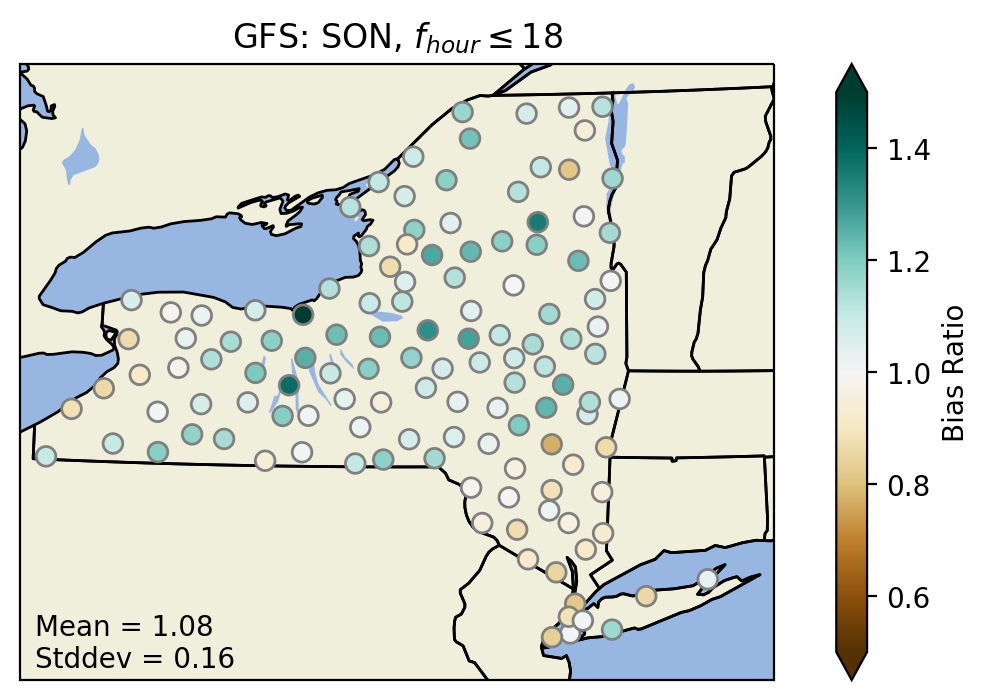

In [32]:
# plotting for each season for <18 fcast hours
seasons = ["DJF", "MAM", "JJA", "SON"]

for season in seasons:
    get_bias_ratio_and_plot(
        hrrr_fcast_and_error_df[
            (hrrr_fcast_and_error_df["season"] == season)
            & (hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18)
        ],
        "HRRR",
        season + ", $f_{hour}\leq$18",
    )
    get_bias_ratio_and_plot(
        nam_fcast_and_error_df[
            (nam_fcast_and_error_df["season"] == season)
            & (hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18)
        ],
        "NAM",
        season + ", $f_{hour}\leq$18",
    )
    get_bias_ratio_and_plot(
        gfs_fcast_and_error_df[
            (gfs_fcast_and_error_df["season"] == season)
            & (hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] <= 18)
        ],
        "GFS",
        season + ", $f_{hour}\leq$18",
    )

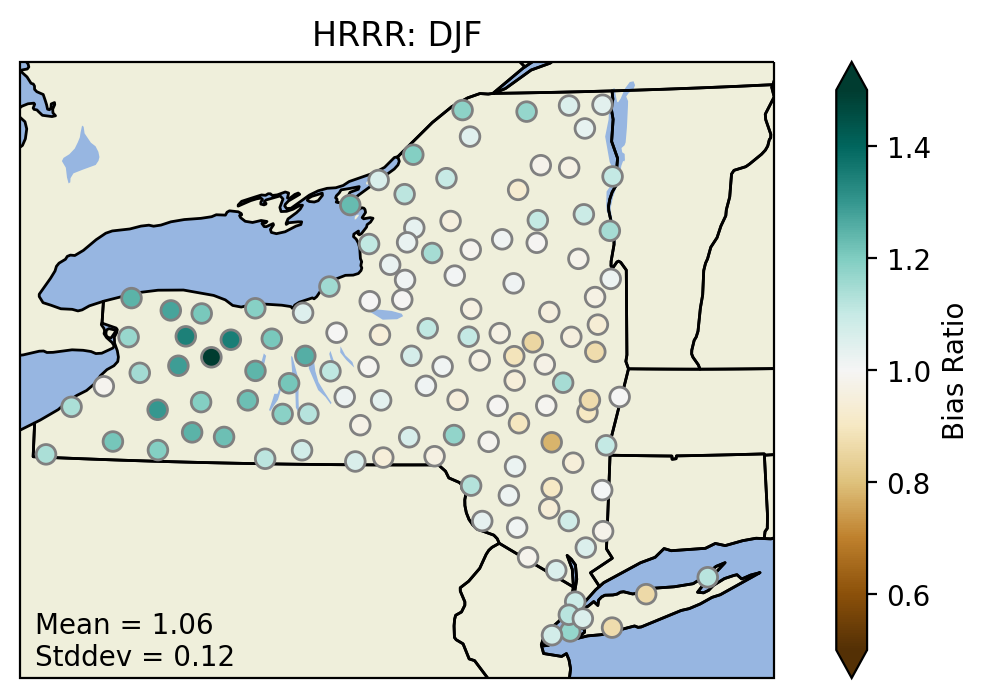

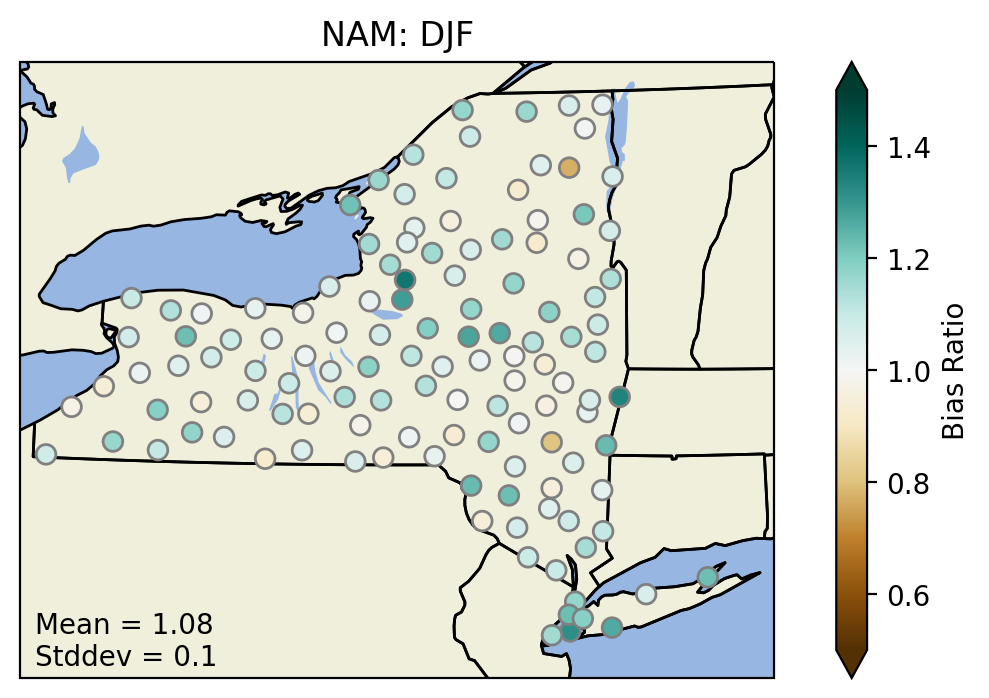

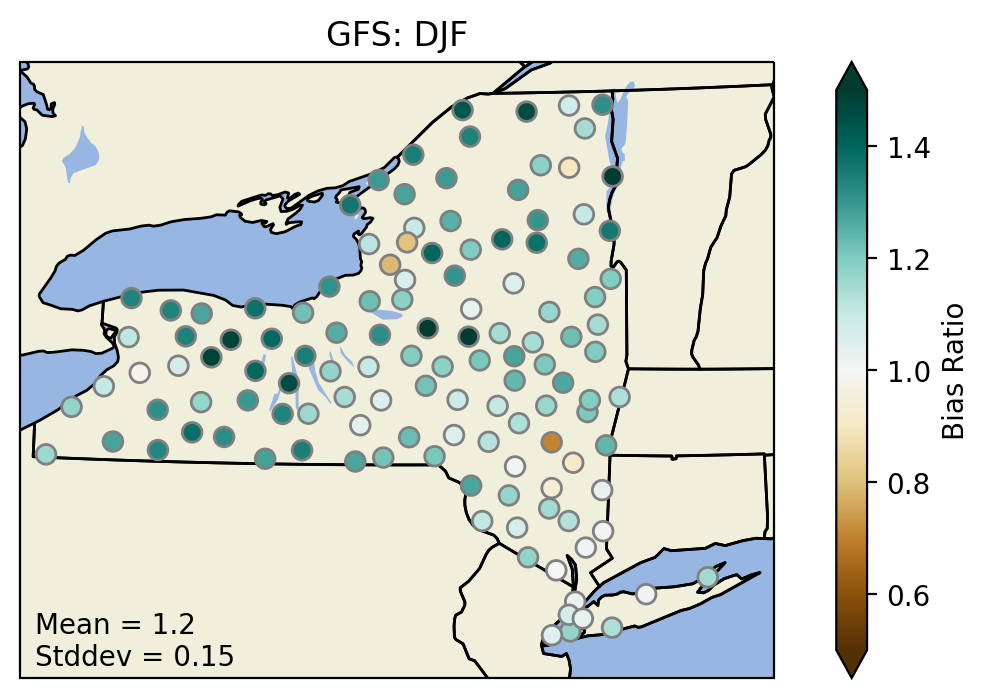

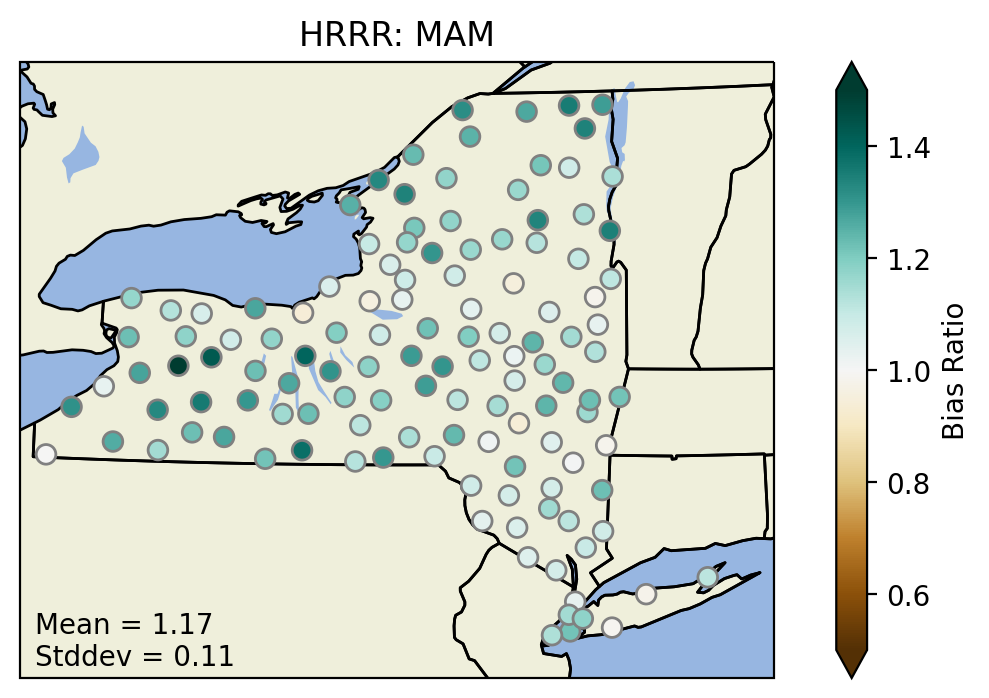

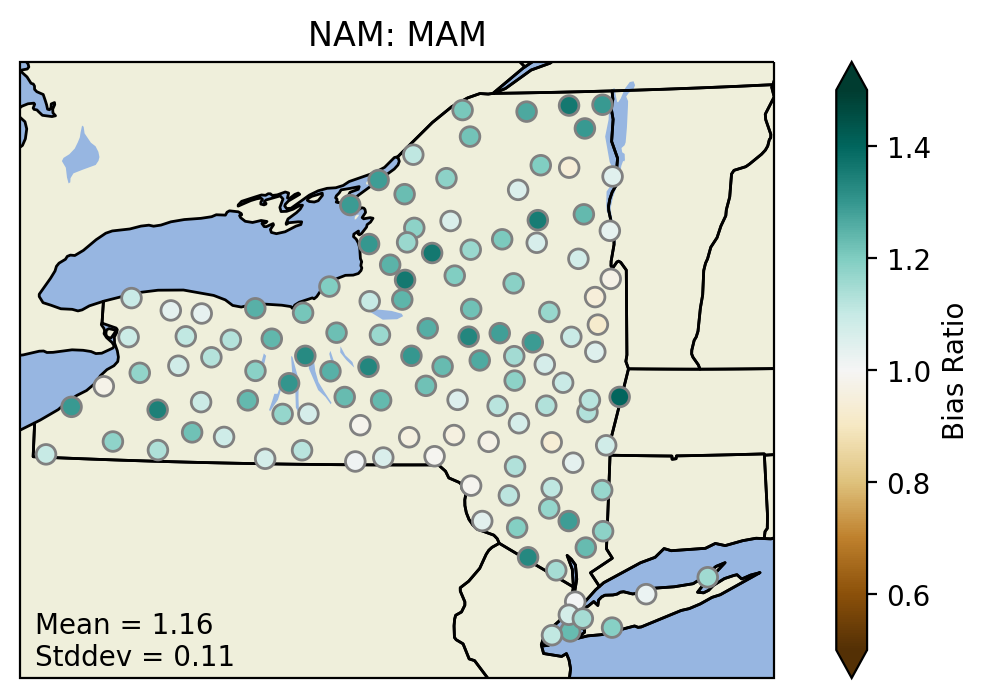

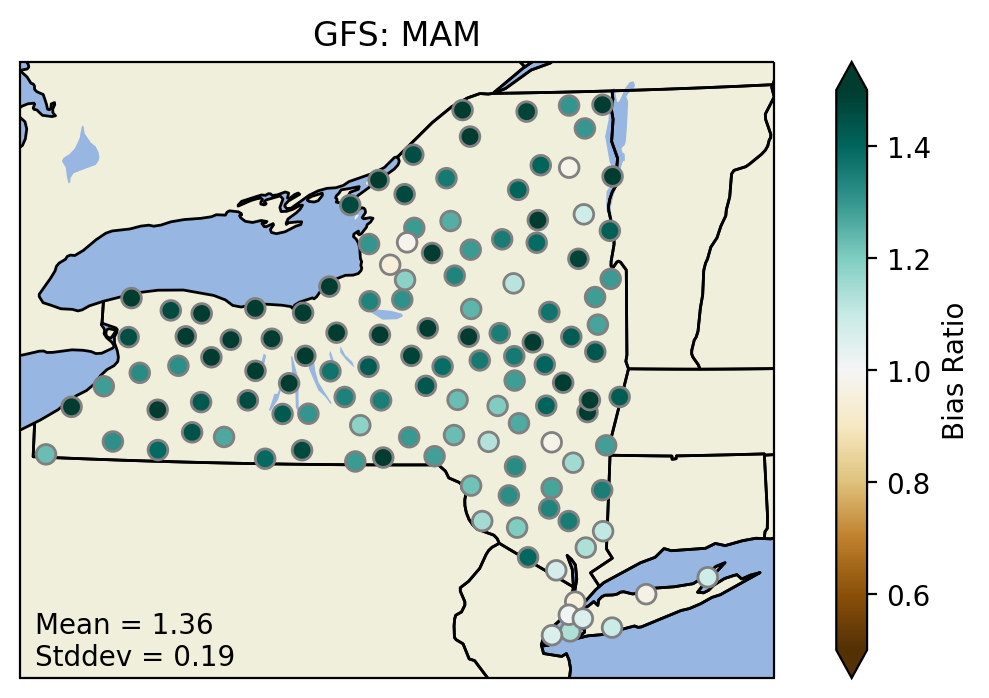

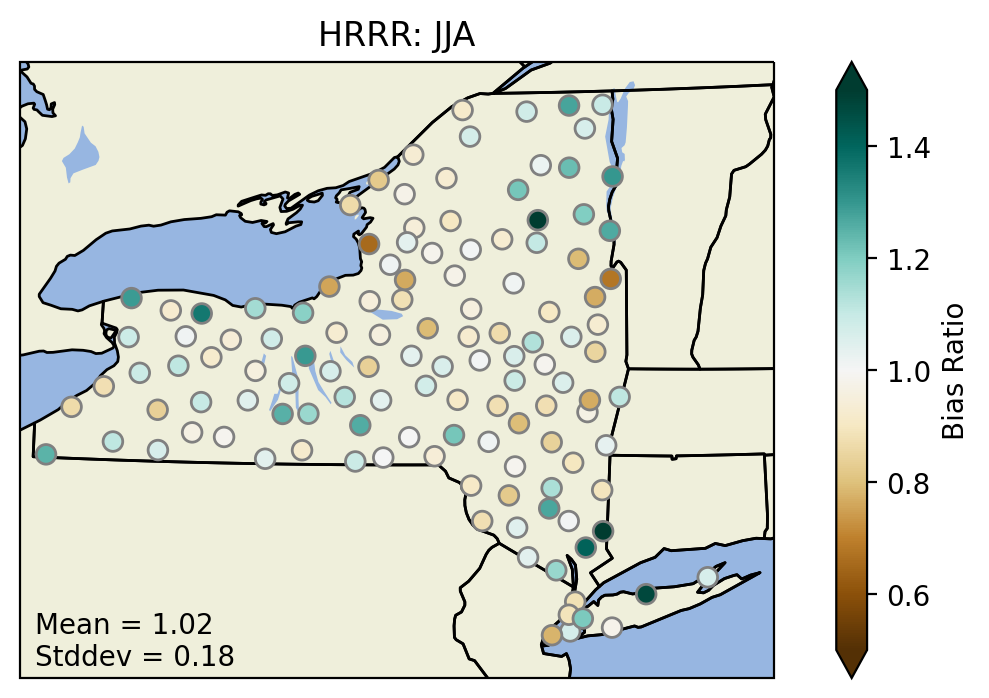

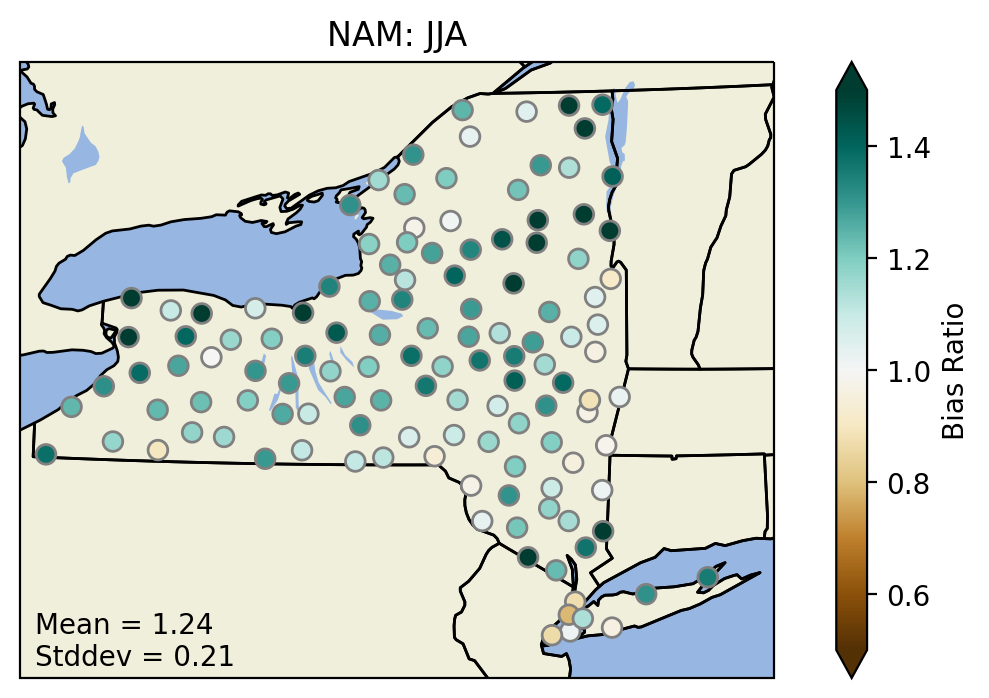

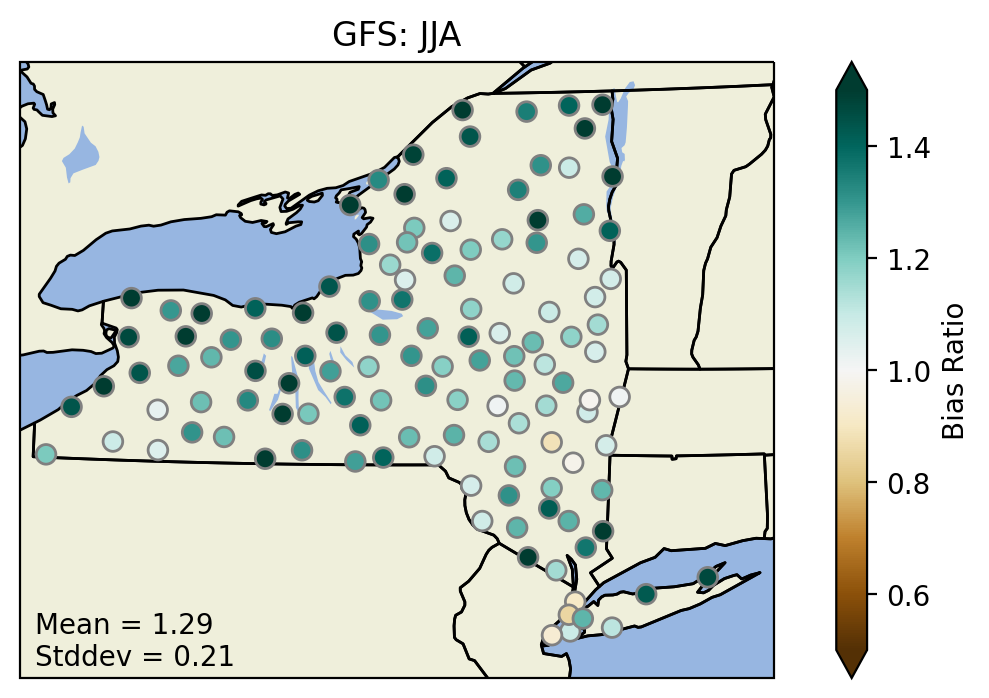

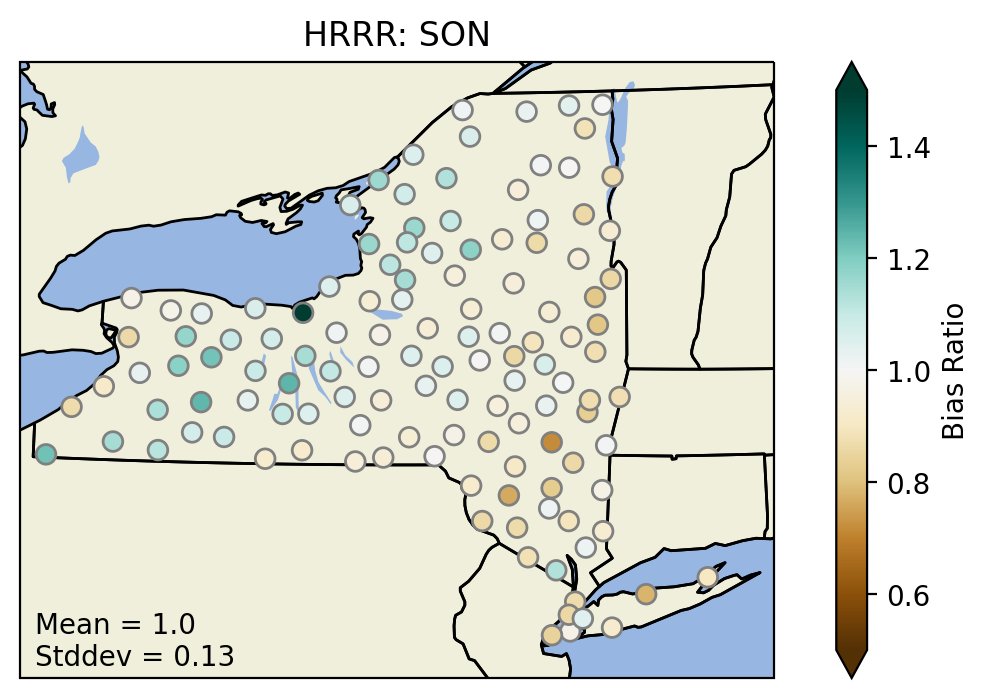

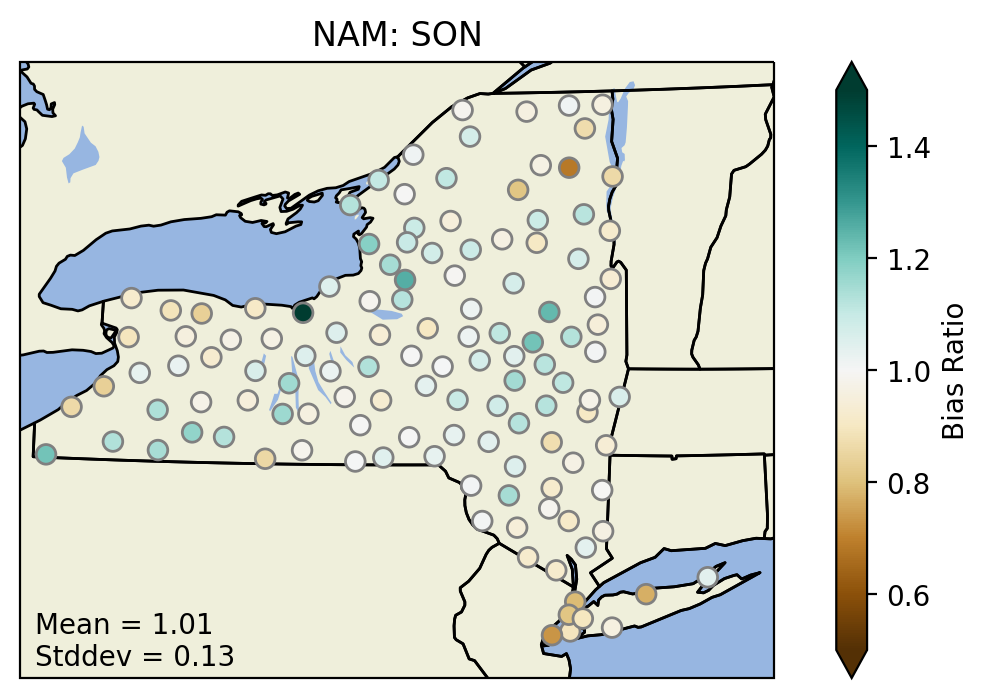

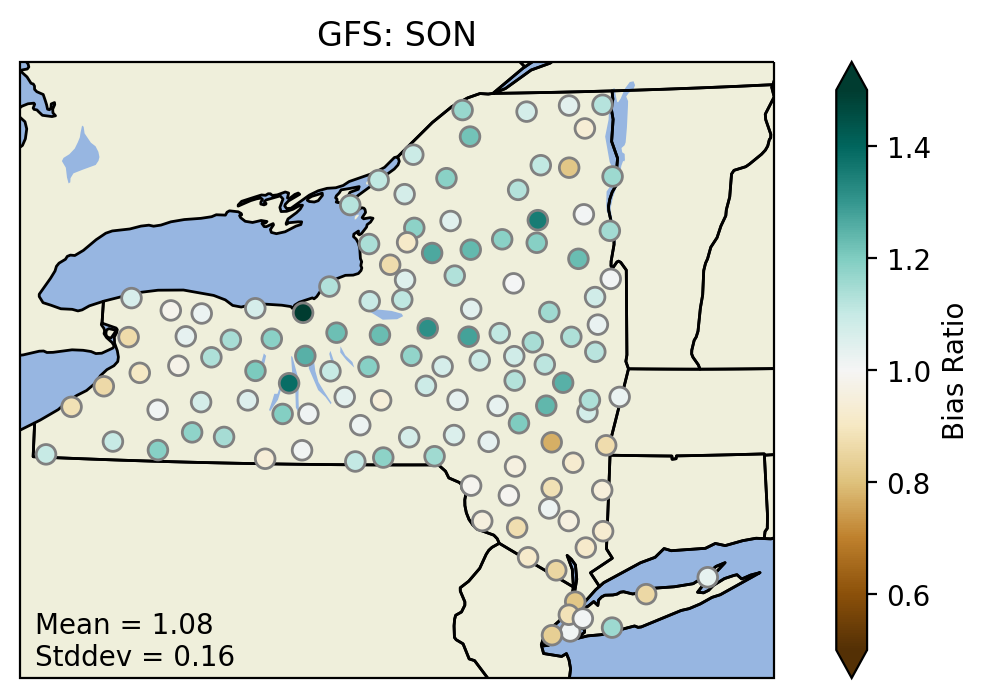

In [33]:
# plotting for each season
seasons = ["DJF", "MAM", "JJA", "SON"]

for season in seasons:
    get_bias_ratio_and_plot(
        hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["season"] == season],
        "HRRR",
        season,
    )
    get_bias_ratio_and_plot(
        nam_fcast_and_error_df[nam_fcast_and_error_df["season"] == season],
        "NAM",
        season,
    )
    get_bias_ratio_and_plot(
        gfs_fcast_and_error_df[gfs_fcast_and_error_df["season"] == season],
        "GFS",
        season,
    )

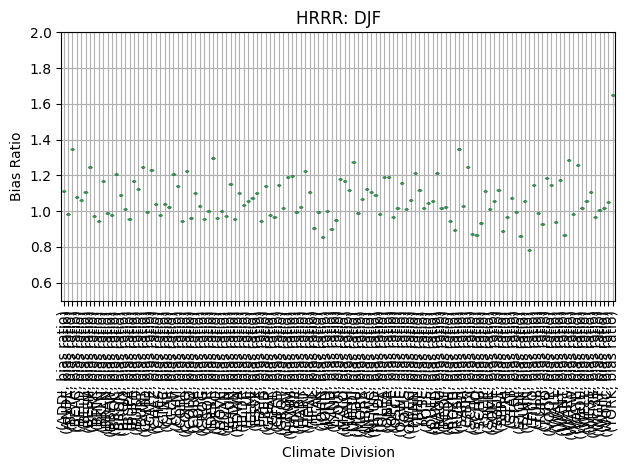

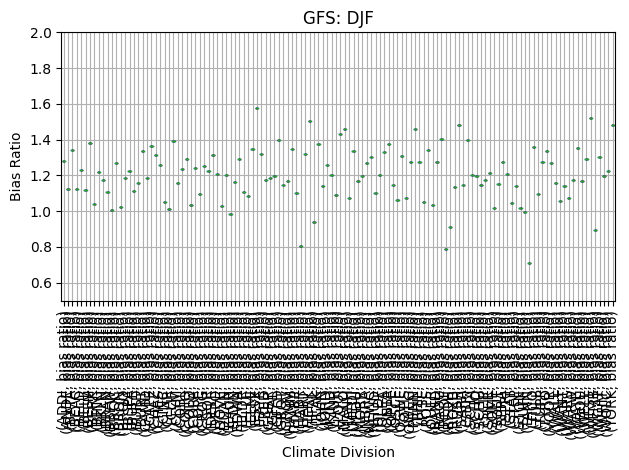

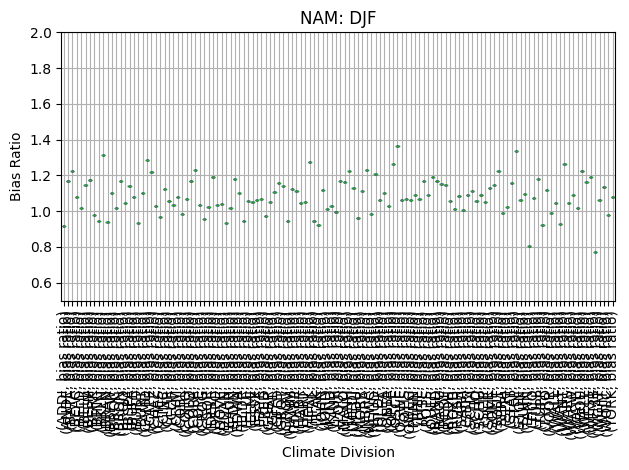

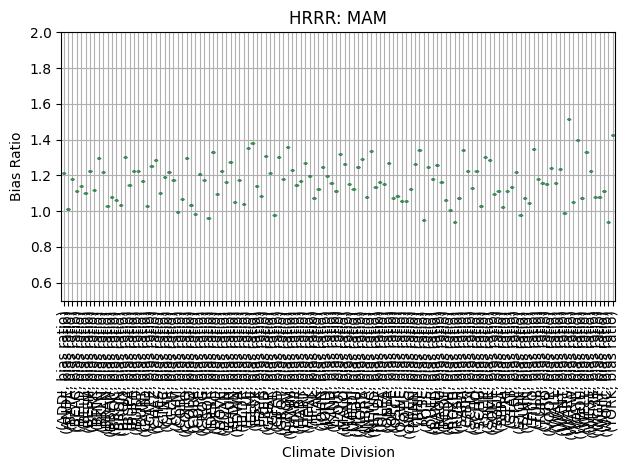

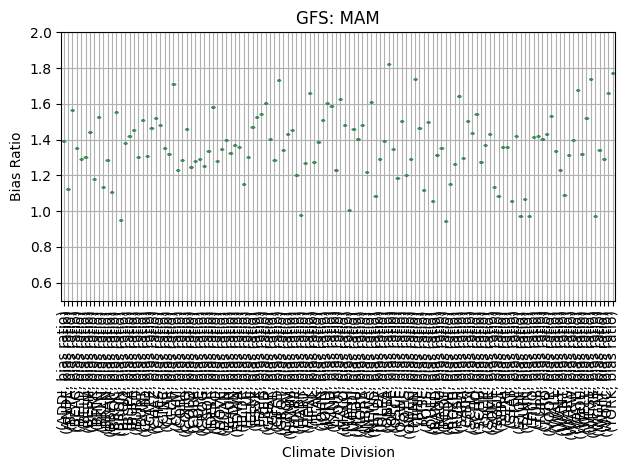

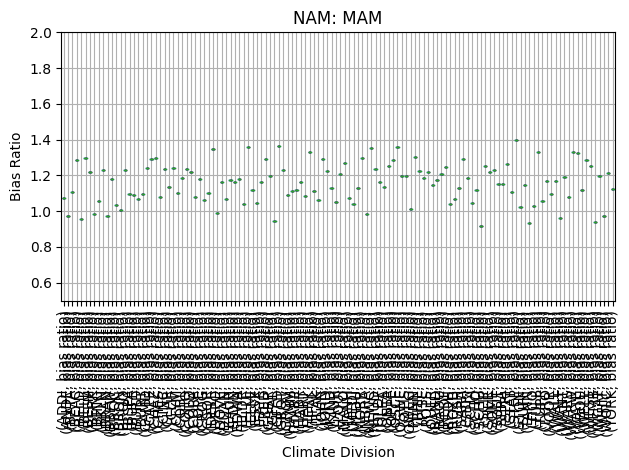

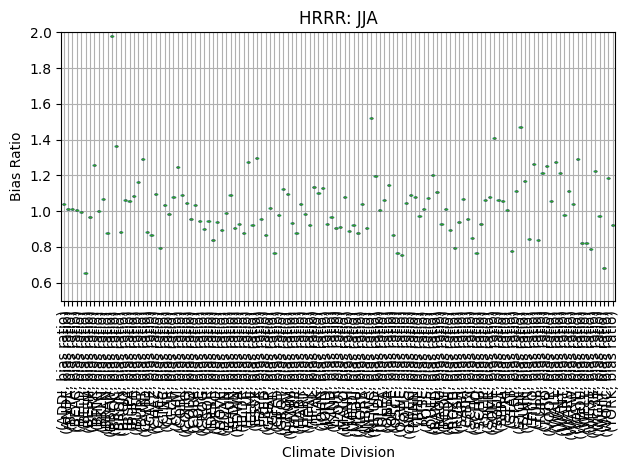

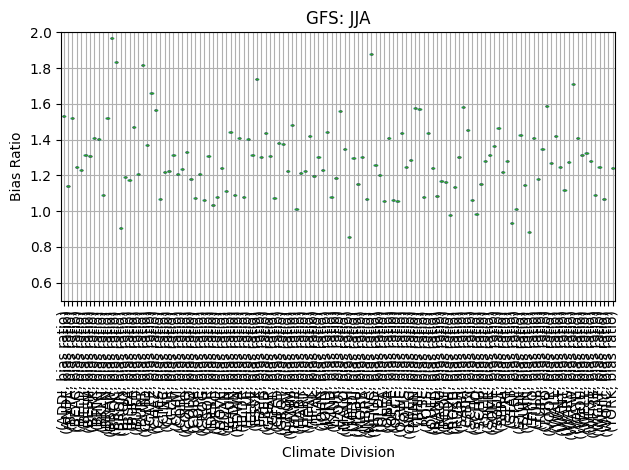

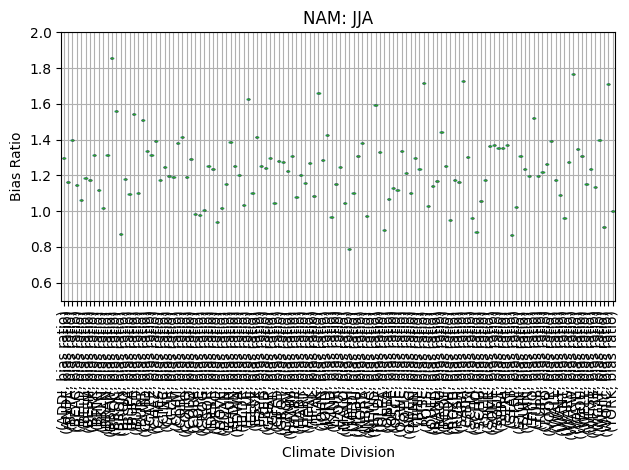

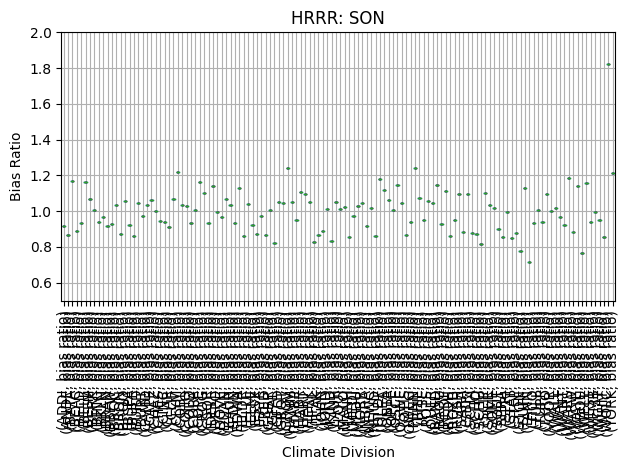

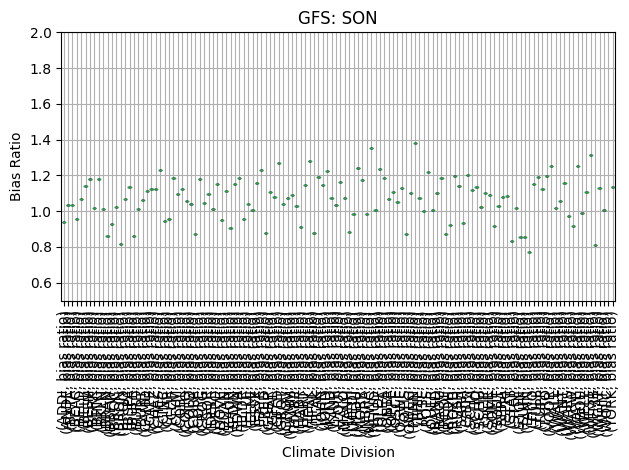

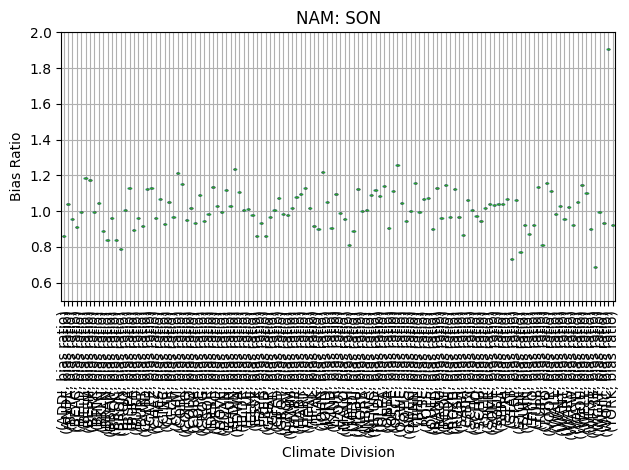

In [34]:
seasons = ["DJF", "MAM", "JJA", "SON"]

for season in seasons:
    plot_bias_ratio_boxplot_season(hrrr_fcast_and_error_df, "HRRR", season)
    plot_bias_ratio_boxplot_season(gfs_fcast_and_error_df, "GFS", season)
    plot_bias_ratio_boxplot_season(nam_fcast_and_error_df, "NAM", season)

In [ ]:
# also curious how these look for each of the model upgrade cycles

# gfs_updates = {'2017-07-19':'NEMS GFS',
#                '2019-06-12':'FV3-based GFS (v15.1)',
#                '2019-11-07':'GFS (v15.2)',
#                '2021-03-22':'GFS (v16)'}

# nam_updates = {'2017-03-21':'Final major upgrade'}

# hrrr_updates = {'2016-08-23':'HRRRv2',
#                 '2018-07-12':'HRRRv3',
#                 '2020-12-02':'HRRRv4'}

# gfs_updates_df = pd.DataFrame.from_dict(gfs_updates, orient='index', columns=['description'])
# nam_updates_df = pd.DataFrame.from_dict(nam_updates, orient='index', columns=['description'])
# hrrr_updates_df = pd.DataFrame.from_dict(hrrr_updates, orient='index', columns=['description'])

In [ ]:
# # set the multiindex before the xs
# gfs_fcast_and_error_df = gfs_fcast_and_error_df.set_index(['station', 'valid_time', 'time'])
# hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.set_index(['station', 'valid_time', 'time'])

In [ ]:
# gfs_updates_df

In [ ]:
# hrrrv2 = hrrr_fcast_and_error_df.xs(slice(hrrr_updates_df.index[0], hrrr_updates_df.index[1]), level='valid_time', drop_level=False).reset_index()
# hrrrv3 = hrrr_fcast_and_error_df.xs(slice(hrrr_updates_df.index[1], hrrr_updates_df.index[2]), level='valid_time', drop_level=False).reset_index()
# hrrrv4 = hrrr_fcast_and_error_df.xs(slice(hrrr_updates_df.index[2], '2021-12-31'), level='valid_time', drop_level=False).reset_index()

In [ ]:
# get_bias_ratio_and_plot(hrrrv2[(hrrrv2['time']>='2018-01-01') & (hrrrv2['time']<='2018-07-10')], 'HRRR', 'v2')
# get_bias_ratio_and_plot(hrrrv3[((hrrrv3['time']>='2019-01-01') & (hrrrv3['time']<='2019-07-10')) |
#                       ((hrrrv3['time']>='2020-01-01') & (hrrrv3['time']<='2020-07-10'))], 'HRRR', 'v3')
# get_bias_ratio_and_plot(hrrrv4[(hrrrv4['time']>='2021-01-01') & (hrrrv4['time']<='2021-07-10')], 'HRRR', 'v4')

In [ ]:
# gfs_NEMS = gfs_fcast_and_error_df.xs(slice(gfs_updates_df.index[0], gfs_updates_df.index[1]), level='valid_time', drop_level=False).reset_index()
# gfs_v15_1 = gfs_fcast_and_error_df.xs(slice(gfs_updates_df.index[1], gfs_updates_df.index[2]), level='valid_time', drop_level=False).reset_index()
# gfs_v15_2 = gfs_fcast_and_error_df.xs(slice(gfs_updates_df.index[2], gfs_updates_df.index[3]), level='valid_time', drop_level=False).reset_index()
# gfs_v16 = gfs_fcast_and_error_df.xs(slice(gfs_updates_df.index[2], '2021-12-31'), level='valid_time', drop_level=False).reset_index()

In [ ]:
# get_bias_ratio_and_plot(gfs_NEMS[(gfs_NEMS['time']>='2018-06-13') & (gfs_NEMS['time']<='2018-11-06')], 'GFS', 'NEMS')
# get_bias_ratio_and_plot(gfs_v15_1[(gfs_v15_1['time']>='2019-06-13') & (gfs_v15_1['time']<='2019-11-06')], 'GFS', 'v15.1')
# get_bias_ratio_and_plot(gfs_v15_2[(gfs_v15_2['time']>='2020-06-13') & (gfs_v15_2['time']<='2020-11-06')], 'GFS', 'v15.2')
# get_bias_ratio_and_plot(gfs_v16[(gfs_v16['time']>='2021-06-13') & (gfs_v16['time']<='2021-11-06')], 'GFS', 'v16')